# Exam score prediction


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

In [81]:
df=pd.read_csv('dataset/Exam_Score_Prediction.csv')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


In [83]:
df_num=df[df.columns[df.dtypes!='object']].copy()
#remove student_id
df_num.drop('student_id',axis=1,inplace=True)

# Linear Relationship between numeric variables

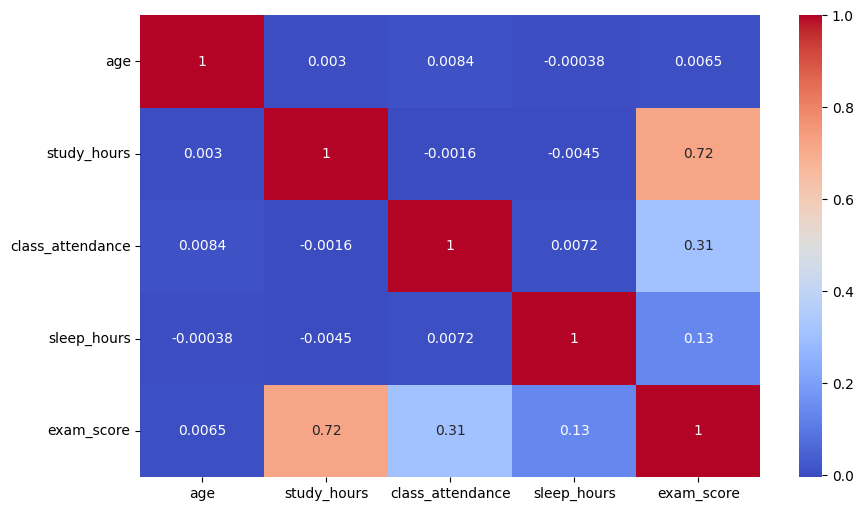

In [84]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(df_num.corr(), annot=True, cmap="coolwarm")
plt.show()

# study_hours and class_attendance are more correlated to exam_score than others variable.


# remove  age from the features

In [85]:
df_r=df.drop(['age'],axis=1)

# Split data into target, train set and test set

In [86]:
y=df['exam_score']
x=df.drop(['age','student_id','exam_score'],axis=1)
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42)

# Encoding non numerical variables:
 ***Without rank (dummies)***:gender,course,study_method   
 ***rank***:internet_access,sleep_quality,facility_rating,exam_difficulty


In [87]:
def prep_features(x):
    '''
    x: The dataframe containing your features
    '''
    # encode the categorical column
    df = pd.get_dummies(x, columns= ['gender', 'course','study_method'], dtype=float)
   
    #columns to rank
    #cols = ['internet_access','sleep_quality','facility_rating','exam_difficulty']
   
    #encode the ordinal data
    order = {
        "internet_access": ['no','yes'],
        "sleep_quality": ['poor','average','good'],
        "facility_rating":['low', 'medium','high'],
        "exam_difficulty":['easy','moderate','hard']
    }
   
    #creating encoderinstance
    lae = sk.preprocessing.LabelEncoder()
   
    #apply it to the columns
    for col, orde in order.items(): #.items allows it access the key and values
        lae.fit(orde)
        df[col + '_label'] = lae.transform(df[col])
       
    df.drop(columns=['internet_access','sleep_quality',
                    'facility_rating','exam_difficulty'], inplace=True)
    return df

In [88]:
order=dict({'internet_access':['no','yes'],'sleep_quality':['poor','average','good'],'exam_difficulty':['easy','moderate','hard'],
           'facility_rating':['low','medium','high']})

In [89]:
x_test=prep_features(x_test)

x_train=prep_features(x_train)

In [90]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(x_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [91]:
predict=model.predict(x_train)


In [92]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_train,predict)

In [93]:
np.sqrt(mse)

np.float64(10.690499081528731)

In [94]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(model,x_train,y_train,cv=10,scoring='neg_mean_squared_error')

In [95]:
np.sqrt(-scores).mean()

np.float64(10.704604479304836)

# KNN regressor

In [96]:
model2=sk.neighbors.KNeighborsRegressor(n_neighbors=5)
model2.fit(x_train,y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [97]:
predict2=model2.predict(x_train)
error=mean_squared_error(y_train,predict2)
np.sqrt(error)

np.float64(9.663568498916192)

In [98]:
score2=cross_val_score(model2,x_train,y_train,cv=10,scoring='neg_mean_squared_error')

In [99]:
np.sqrt(-score2).mean()

np.float64(11.835956618125211)

# Test phase

In [100]:
y_predict1=model.predict(x_test)
np.sqrt(mean_squared_error(y_predict1,y_test))

np.float64(10.731551961536836)

In [101]:
y_predict2=model2.predict(x_test)
np.sqrt(mean_squared_error(y_predict2,y_test))

np.float64(11.800934004986555)

# Neural Nework 

In [102]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets,transforms

In [103]:
class firstview:
    '''
    Helper class for split_num_cat_features class. It helps for first contact with a dataset.
    
    CatVar: returns categorical variables in the dataset
    NumVar: returns numerical variables in the dataset
    InfoCatVar: returns list of each categorical variable with the frequence of their level.
    
    '''
    def __init__(self,x):
        self.df=x
    def CatVar(self):
        ''' Identifies categorical columns'''
        return self.df.columns[self.df.dtypes=='object']
    def NumVar(self):
        '''Identifies numerical colunms'''
        return self.df.columns[self.df.dtypes!='object']
    def InfoCatVar(self):
        var=self.CatVar()
        return [self.df[j].value_counts() for j in var]
        
class split_num_cat_features(firstview):
    '''
    Transform categorical columns in numerical using LabelEncoder
    from sklearn.preprocessing.LabelEncoder
    '''
    def __init__(self,x):
        self.df=x
    def get_transform(self):
        '''Applies LabelEncoder to each categorical column'''
        categorical_columns=self.CatVar()
        numerical_columns=self.NumVar()
        for col in categorical_columns:
            self.df[col]=encoder.fit_transform(self.df[col])
        #######
        self.df[numerical_columns]=scaler.fit_transform(self.df[numerical_columns])
        return self.df   

In [104]:
class swish(nn.Module):
    ''' Adapts activation function swish to be used in Pytorch'''
    def __init__(self):
        super(swish,self).__init__()
    def forward(self,x):
        return x*torch.sigmoid(x)
        
class preparedata(Dataset):
    '''
    Custom PyTorch Dataset class to prepare data for model training.
    It defines how many samples exist and how to retrieve one sample (data, label).
    '''
    def __init__(self,df,target,categorical_columns):
        self.y=torch.tensor(target.values,dtype=torch.float32).reshape(-1,1)
        self.df_cat=torch.tensor(df[categorical_columns].values.copy(),dtype=torch.long)
        self.df_num=torch.tensor(df.drop(categorical_columns,axis=1).copy().values,dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        return self.df_num[idx],self.df_cat[idx],self.y[idx]


class Model(nn.Module):
    ''' Custom PyTorch Module class to define the model to be adjusted to data.
    '''
    def __init__(self,df,categorical_columns,embed_dim=3):
        super().__init__()
        self.embed_instance=nn.ModuleList([nn.Embedding(df[col].nunique(),embed_dim) for col in categorical_columns])
        size_catvar=embed_dim*len(categorical_columns)
        total_size=size_catvar+len(df.columns)-len(categorical_columns)
        self.linear1=nn.Linear(total_size,10)
        self.act1=nn.ReLU()
        self.linear2 = nn.Linear(10, 7)
        self.act2=nn.ReLU()
        self.linear3 = nn.Linear(7, 3)
        self.act3=nn.ReLU()
        self.linear4 = nn.Linear(3, 1)
        
    def forward(self,x_num,x_cat):
        regroupe_embed=[]
        for i,emb in enumerate(self.embed_instance):
            regroupe_embed.append(emb(x_cat[:,i]))
        x_embed=torch.cat(regroupe_embed,1)
        x_train=torch.cat([x_num,x_embed],1)
        x=self.linear1(x_train)
        x=self.act1(x)
        x=self.linear2(x)
        x=self.act2(x)
        x=self.linear3(x)
        x=self.act3(x)
        x=self.linear4(x)
        return x
        

In [106]:
x_train,x_test,y_train,y_test=sk.model_selection.train_test_split(x,y,test_size=0.2,random_state=42)
encoder=sk.preprocessing.LabelEncoder()
scaler=sk.preprocessing.StandardScaler()

data=split_num_cat_features(x_train)

data_test=split_num_cat_features(x_test)

categorical_columns=data.CatVar()

df_train=data.get_transform()

df_test=data_test.get_transform()

train_dataset=preparedata(df_train,y_train,categorical_columns=categorical_columns)

test_dataset=preparedata(df_test,y_test,categorical_columns=categorical_columns)

train_loader=DataLoader(train_dataset,batch_size=30,shuffle=True,drop_last=False)

test_loader=DataLoader(test_dataset,batch_size=30,shuffle=False,drop_last=False)

device=torch.device('cpu')

# Model definition, criterion selection and omptimizer selection

In [107]:

model=Model(df_train,categorical_columns).to(device)
criterion=torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Model training

In [108]:
epochs = 10
model.train()
loss_list=[]
for i in range(epochs):
    running_loss = 0
    for x_num,x_cat,y in train_loader:
        x_num=x_num.to(device)
        x_cat=x_cat.to(device)
        y=y.to(device)
        optimizer.zero_grad()
        outputs=model(x_num,x_cat)
        loss=criterion(y,outputs)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
    epoch_loss=running_loss/len(train_loader)
    loss_list.append(epoch_loss)

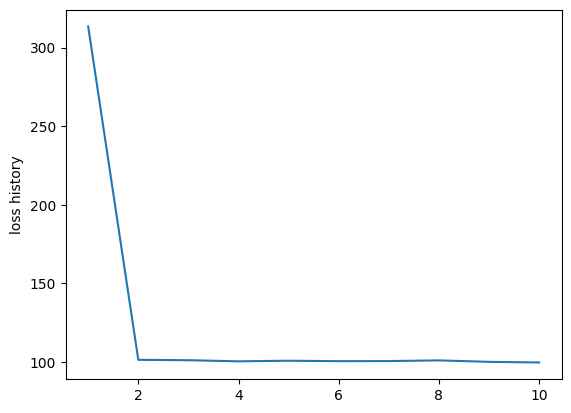

In [109]:

plt.plot(range(1,len(loss_list)+1),loss_list)
plt.ylabel('loss history');

In [110]:
model.eval()
test_loss = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for x_num, x_cat, y in test_loader:

        x_num = x_num.to(device)
        x_cat = x_cat.to(device)
        y = y.to(device)

        # forward pass
        outputs = model(x_num, x_cat)

        # compute loss
        loss = criterion(outputs, y)
        test_loss += loss.item()

        all_preds.append(outputs.cpu())
        all_targets.append(y.cpu())

In [111]:
pred=torch.cat(all_preds,0)
y_tar=torch.cat(all_targets,0)
mse = ((pred - y_tar) ** 2).mean().item()
print("MSE:", mse**0.5)

MSE: 9.904528158350137


# Model Stability

In [112]:
mse_list=[]
seeds=np.arange(42,58)
for seed in seeds:
    y=df['exam_score']
    x=df.drop(['age','student_id','exam_score'],axis=1)
    x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=seed)
    encoder=sk.preprocessing.LabelEncoder()

    data=split_num_cat_features(x_train)
    
    data_test=split_num_cat_features(x_test)
    
    categorical_columns=data.CatVar()
    
    df_train=data.get_transform()
    
    df_test=data_test.get_transform()
    
    train_dataset=preparedata(df_train,y_train,categorical_columns=categorical_columns)
    
    test_dataset=preparedata(df_test,y_test,categorical_columns=categorical_columns)
    
    train_loader=DataLoader(train_dataset,batch_size=30,shuffle=True,drop_last=False)
    
    test_loader=DataLoader(test_dataset,batch_size=30,shuffle=False,drop_last=False)
    
    device=torch.device('cpu')
    #################################################################################
    model=Model(df_train,categorical_columns).to(device)
    criterion=torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    #################################################################################
    epochs = 15
    model.train()
    loss_list=[]
    for i in range(epochs):
        running_loss = 0
        for x_num,x_cat,y in train_loader:
            x_num=x_num.to(device)
            x_cat=x_cat.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            outputs=model(x_num,x_cat)
            loss=criterion(y,outputs)
            loss.backward()
            optimizer.step()
            running_loss +=loss.item()
        epoch_loss=running_loss/len(train_loader)
        loss_list.append(epoch_loss)
    #################################################################################
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for x_num, x_cat, y in test_loader:
    
            x_num = x_num.to(device)
            x_cat = x_cat.to(device)
            y = y.to(device)
    
            # forward pass
            outputs = model(x_num, x_cat)
    
            # compute loss
            loss = criterion(outputs, y)
            test_loss += loss.item()
    
            all_preds.append(outputs.cpu())
            all_targets.append(y.cpu())
####################################################################
    pred=torch.cat(all_preds,0)
    y_tar=torch.cat(all_targets,0)
    mse = ((pred - y_tar) ** 2).mean().item()
    mse_list.append(mse**0.5)

#  MSE for 16 different seeds.

In [113]:
mse_list

[9.865995526900283,
 10.012476576493162,
 9.779656716155218,
 10.08062438726438,
 9.972082842529023,
 10.116841361115462,
 9.961603072126572,
 9.84484392173191,
 9.962352457712948,
 10.016302172164215,
 19.921489732794285,
 10.139741691594793,
 10.503981425795509,
 9.893900107560158,
 9.952204351798697,
 10.07155301404635]

# Average MSE

In [114]:
sum(mse_list)/len(mse_list)

10.630978084861434